In [32]:
from train import WNetAE
import torch

In [33]:
net = WNetAE.load_from_checkpoint(
    "/data2/vqvae-ckpt/run_fft/last.ckpt",
    dim=32,
    f=16,
    bits=32,
    num_blocks=2,
    mults=[1, 2, 2, 4, 4],
    u_net_stages=1,
    mse_weight=1.0,
    lpips_weight=0.1,
    aux_weight=0.1,
    ff_mult=1,
    use_fft=True,
    use_depthwise=False,
    use_ddp=True,
)
net.eval().requires_grad_(False)
net = net.cpu()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/jack/.conda/envs/vqvae/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [34]:
book_modules = net.net.encoder.codebooks
embs = torch.stack([layer._codebook.embed for layer in book_modules.layers]).detach()
embs.shape

torch.Size([32, 2, 16])

In [35]:
from einops import rearrange

In [36]:
flat_embs = rearrange(embs, 'b i d -> (b i) d')
orthogonality = torch.einsum('id,jd->ij', flat_embs, flat_embs)

In [37]:
map = orthogonality * (1 - torch.eye(flat_embs.size(0)))

In [38]:
mags = embs.pow(2).sum(dim=-1).sqrt()

In [39]:
import matplotlib.pyplot as plt

In [40]:
mag_mins = mags[:,0].minimum(mags[:,1])
mag_maxs = mags[:,0].maximum(mags[:,1])

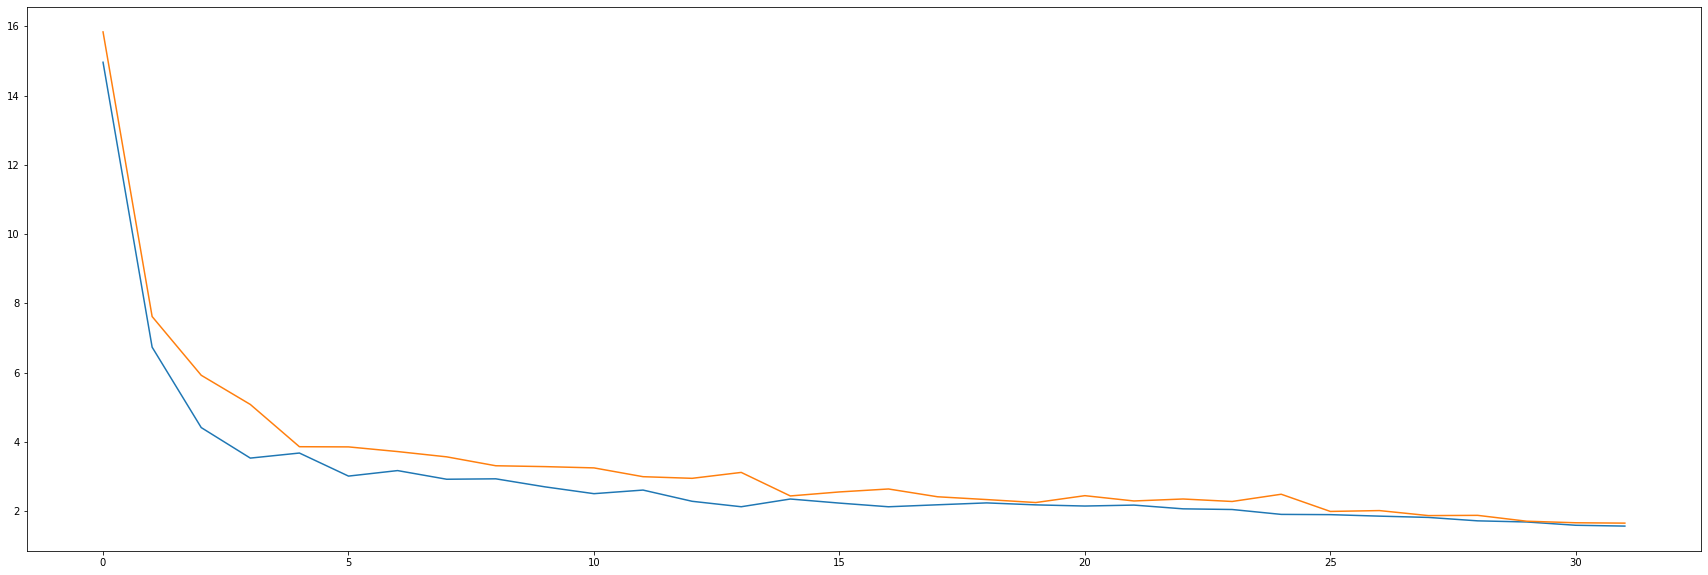

In [41]:
plt.figure(figsize=(30,10))
plt.plot(mag_mins)
plt.plot(mag_maxs)
#plt.yscale('log')

In [42]:
from loader import ImageFolder
from pathlib import Path

ds = ImageFolder(Path('/data1/DALLE-datasets/general/cc12'), 'ixs_filtered.txt', 256, 'images')

In [43]:
import torchvision.transforms.functional as TF

In [44]:
def blend(left, right, bits):
    noflip = torch.arange(0, bits, 1, device=left.device)[None,:,None,None]
    doflip = torch.arange(0, bits, 1, device=left.device)[:,None,None,None]
    return torch.where(noflip < doflip, left, right)

In [45]:
mk_img = lambda t: TF.to_pil_image(t.add(1).div(2).clamp(0, 1))
it = ds[103]
in_img = mk_img(it)
rc_img = mk_img(net.net(ds[103][None])[0][0])

In [46]:
_, ixs, _ = net.net.encoder(it[None])
flipped_ixs = 1 - ixs

In [48]:
ixs_neg = blend(ixs, flipped_ixs, 32)
ixs_rand = blend(ixs, torch.randint_like(ixs, 0, 2), 32)

In [49]:
import torch.nn.functional as F

In [50]:
make_qs = lambda ixs, embs: torch.einsum('bchwi,cid->bdhw', F.one_hot(ixs).to(dtype=embs.dtype), embs)
qs_neg = make_qs(ixs_neg, embs)
qs_rand = make_qs(ixs_rand, embs)

TypeError: <lambda>() missing 1 required positional argument: 'embs'

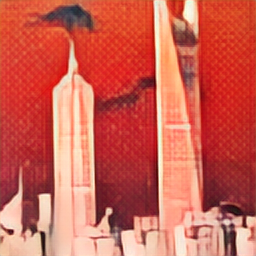

In [ ]:
rc_neg = net.net.decoder(qs_neg)
rc_rand = net.net.decoder(qs_rand)

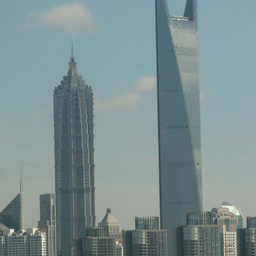

In [ ]:
in_img

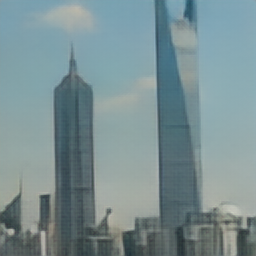

In [ ]:
rc_img

In [ ]:
from torchvision.utils import make_grid

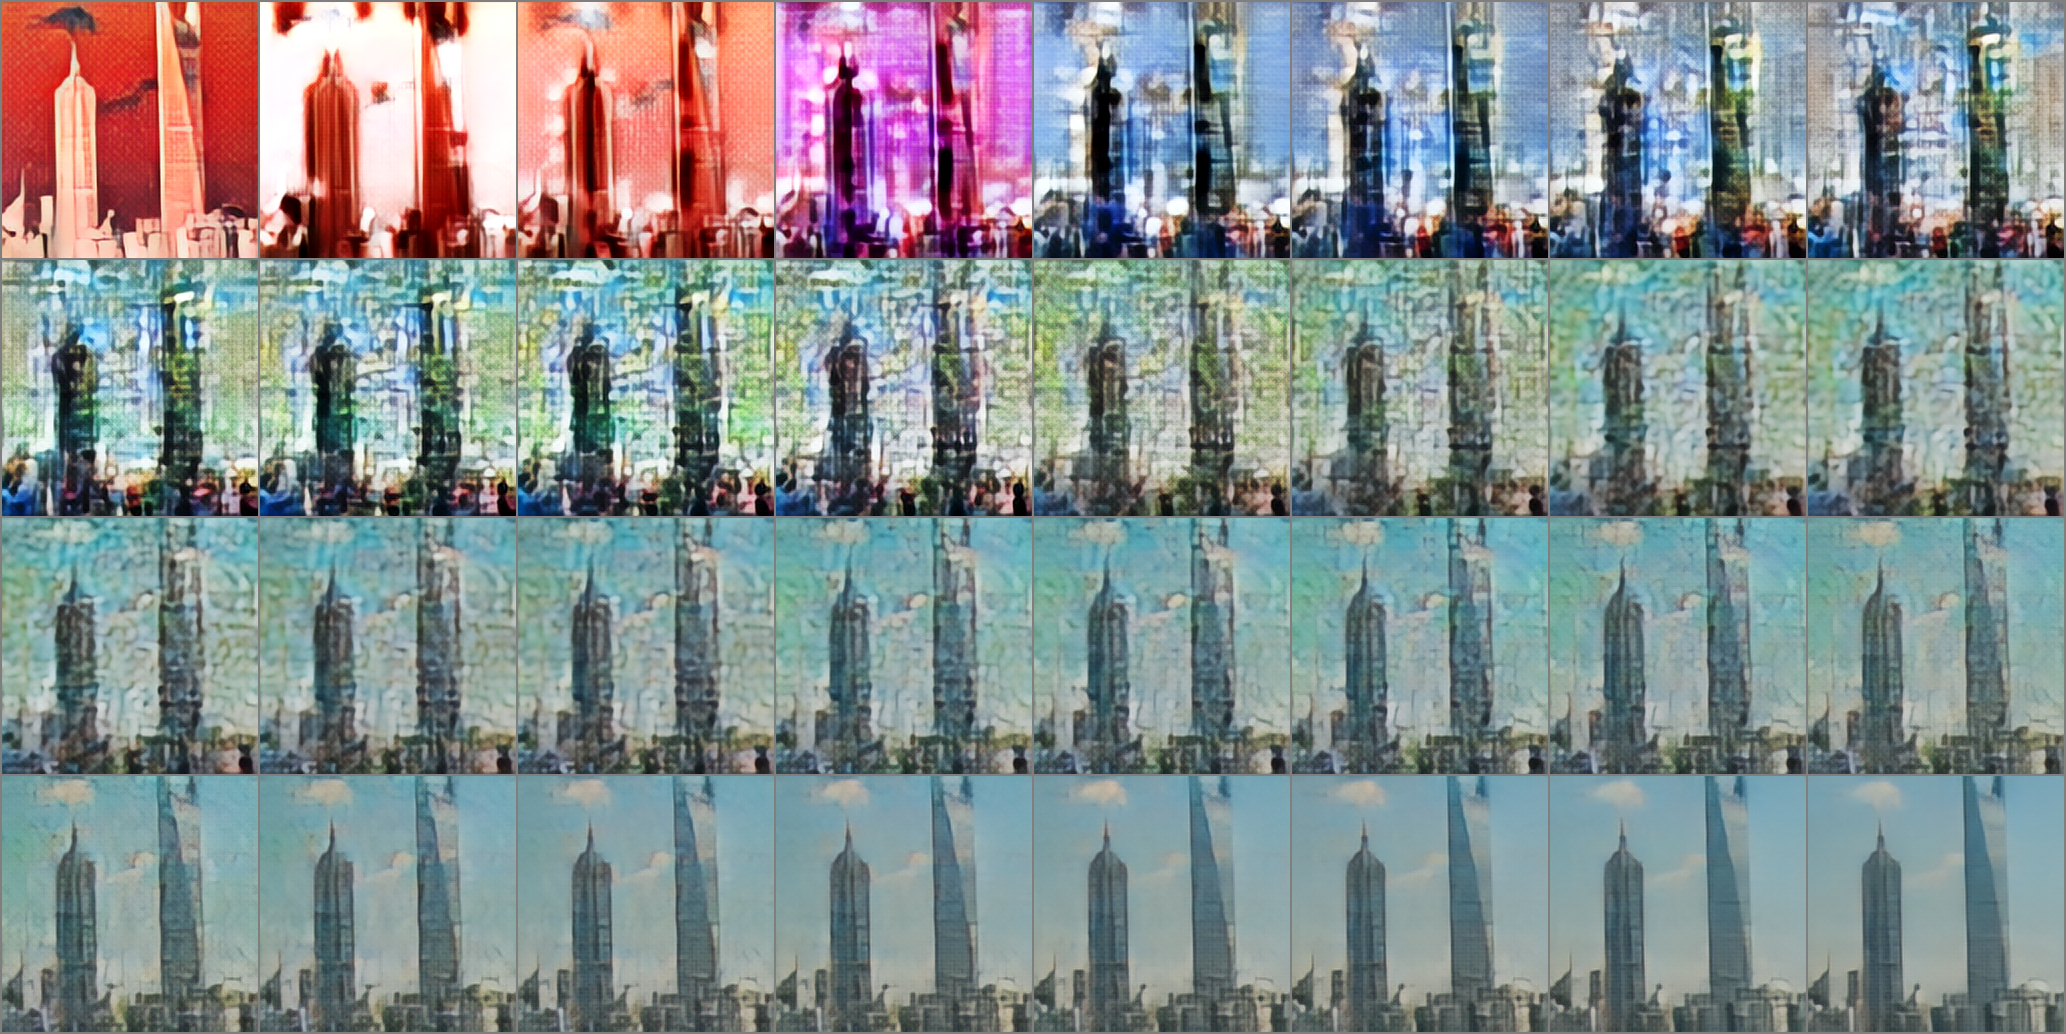

In [ ]:
neg_grid = mk_img(make_grid(rc_neg, nrow=8))
rand_grid = mk_img(make_grid(rc_rand, nrow=8))

In [ ]:
def decode(ixs):
    qs = torch.einsum('bchwi,cid->bdhw',F.one_hot(ixs).to(dtype=torch.float32), embs)
    return net.net.decoder(qs)

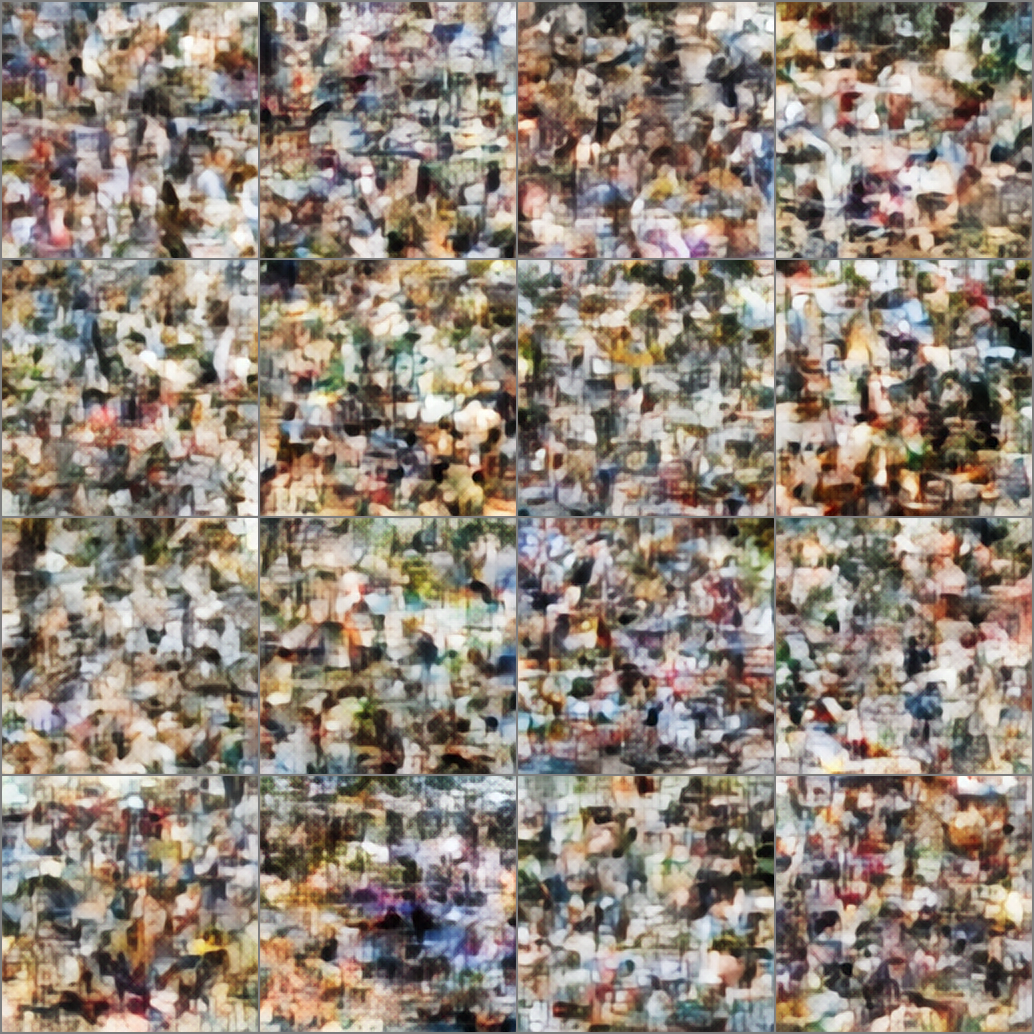

In [ ]:
mk_img(make_grid(decode(torch.randint(0, 2, [16, 32, 16, 16])), nrow=4))